In [1]:
import torch
from IPython import display
from d2l import torch as d2l


In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [3]:
# 读取数据集
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="data",train=False,transform=trans,download=True)


In [4]:
# 训练集和测试集分别包含60000和10000张图像
# 每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1
# Fashion-MNIST中包含的10个类别
def get_fashion_minst_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

get_fashion_minst_labels([1,3,5])

['trouser', 'dress', 'sandal']

In [5]:
# 创建一个函数来可视化这些样本
def show_images(imgs,num_rows,num_cols,titles=None,scale=1.5):
    figsize = (num_cols*scale,num_rows*scale)
    _,axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = axes.flatten()
    for i ,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

torch.Size([18, 1, 28, 28])


array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

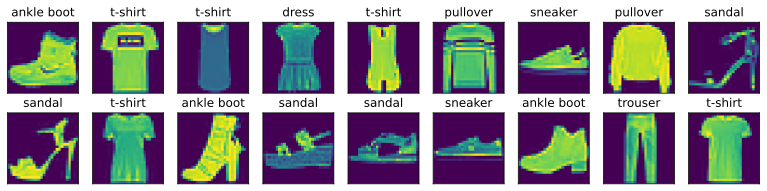

In [6]:
X,y = next(iter(data.DataLoader(mnist_train,batch_size=18)))
print(X.shape)
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_minst_labels(y))

In [7]:
# 读取小批量
batch_size = 256

train_iter = data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)

timer = d2l.Timer()
for X, y in train_iter:
    continue
f"{timer.stop():.2f} sec"

'2.48 sec'

In [17]:
#整合所有组件
def load_data_fashion_minst(batch_size,resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="data",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="data",train=False,transform=trans,download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [18]:

# softmax 实现
import torch
from IPython import display


In [20]:
batch_size = 256
train_iter,test_iter = load_data_fashion_minst(batch_size)


784


In [35]:
def softmax(X):
    x_exp = torch.exp(X)

    partiton = x_exp.sum(1,keepdim=True)

    return x_exp / partiton
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
print(X_prob)

tensor([[0.3308, 0.1058, 0.0358, 0.3813, 0.1463],
        [0.0696, 0.1513, 0.0392, 0.3231, 0.4168]])


In [33]:
# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)



In [24]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [26]:
# 定义损失函数 ，也就是交叉熵损失
def loss(y_hat,y):
    # 本来的是求和yi*log(yi毛)  但是yi只关注分对的，也就是值为1的，所以只需要知道目标类和当前分的yi毛就可以了，因为其它的都是0 
    return -torch.log(y_hat[range(len(y_hat)),y])

loss(y_hat,y)

tensor([0.1000, 0.5000])


tensor([2.3026, 0.6931])

In [28]:
def accurancy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [29]:
accurancy(y_hat, y) / len(y)

0.5

In [30]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [31]:
# 同样，对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。
def evaluate_accurancy(net,data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accurancy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [36]:
evaluate_accurancy(net, test_iter)

0.1284

In [57]:
def train_epoch(net,train_iter,loss,updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    
    metric = Accumulator(3)

    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        
        metric.add(float(l.sum()), accurancy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [58]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        
        display.clear_output(wait=True)

In [59]:
def train(net,train_iter,test_iter,loss,epochs,updater):
    animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accurancy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [60]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

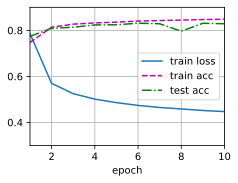

In [62]:
num_inputs = 28*28
num_outputs = 10
W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, updater)

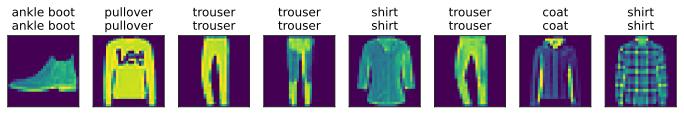

In [65]:
def predict_ch3(net, test_iter, n=8):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_minst_labels(y)
    preds = get_fashion_minst_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)